# **Defining Expression Level Categories (ELC-analysis)**

## **Content**
### 1. ELC-analysis for barplots
### 2. ELC-analysis for PCA-s on non-normalised TPM counts
### 3. ELC-analysis for PCA-s on VS TPM counts
### 4. Calculating expression bias

In [2]:
library(data.table, warn.conflicts = FALSE)
library(RPostgreSQL)
library(foreach, warn.conflicts = FALSE)
library(tidyverse, warn.conflicts = FALSE)
library(FactoMineR, warn.conflicts = FALSE)
library(factoextra, warn.conflicts = FALSE)
library(RColorBrewer)
library(cowplot, warn.conflicts = FALSE)
library(DESeq2, warn.conflicts = FALSE)

In [3]:
set.seed(42) # For reproducibility of results

In [4]:
# import count table
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
hord <- readRDS("wheat_count_table_merged.rds")
h <- hord$counts
dim(h)
head(h)
# dimensions shows that a total of 193 samples were mapped to 49 281 genes of H.vulgare

[1] 123075    215

,SRR10737427,SRR10737428,SRR10737429,SRR10737430,SRR10737431,SRR10737432,CRR088963,CRR088962,CRR088961,CRR088960,⋯,SRR8413505,SRR8413506,SRR8413507,SRR8413508,SRR5186313,SRR5186364,SRR5186375,SRR5186382,SRR5186387,SRR5186416
TraesCHI1A01G000100,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0000,⋯,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TraesCHI1A01G000200,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0000,⋯,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TraesCHI1A01G000300,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0000,⋯,6.0000,7.878112,14.0000,1.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TraesCHI1A01G000400,0.0000,0.000000,0.0000,4.893036,4.726423,1.938802,0.0000,0.000000,0.0000,0.0000,⋯,140.5432,108.839845,177.3651,112.3966,1.993108,0.000000,0.000000,0.000000,2.004102,0.000000
TraesCHI1A01G000500,1.0000,8.000000,7.0000,9.000000,2.000000,3.000000,1.0000,8.000000,7.0000,9.0000,⋯,5.0000,11.000000,12.0000,5.0000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000
TraesCHI1A01G000600,193.3952,2.465932,159.4838,51.088736,8.853329,80.785644,193.3877,2.465675,159.5168,126.3058,⋯,387.2507,513.135328,458.2691,355.3096,0.000000,2.649372,1.307648,4.297154,4.083578,1.356089


In [5]:
# import metadata
setwd("/home/vanda.marosi/floral_development_thesis_vm/datatables/")
# stringsAsfactors has to be truse for deseq2 design
wheat_metadata <- read.table("wheat_final.csv", header = TRUE, sep = ",", stringsAsFactors = TRUE)
wheat_meta <- select(wheat_metadata, Run.ID, Dataset, Batch, Cultivar, GM, Zadok_scale, Intermediate_age, High_level_age, Intermediate_tissue, High_level_tissue, Treatment, RNA_extraction, RNA_enrichment, RNA_input..microg., PCR_purification, Growth_condition, Day_night_condition, Temperature_day_night_c, Growth_location, Seq_location, Instrument, Library.layout)
colnames(wheat_meta) <- c("ID", "dataset", "batch", "cultivar", "gm", "zadoc_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")
# add rownames for deseq2 to identify rows with count-columns
rownames(wheat_meta) <- wheat_meta$ID
glimpse(wheat_meta)
tail(wheat_meta)

Rows: 215
Columns: 22
$ ID                  <fct> SRR10737427, SRR10737428, SRR10737429, SRR1073743…
$ dataset             <fct> cytoplasmic_male_sterility, cytoplasmic_male_ster…
$ batch               <int> 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6…
$ cultivar            <fct> 303-B, 303-B, 303-B, C303A, C303A, C303A, B706, B…
$ gm                  <fct> wt, wt, wt, mut, mut, mut, wt, wt, wt, mut, mut, …
$ zadoc_scale         <int> 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 5…
$ intermediate_age    <fct> Heading, Heading, Heading, Heading, Heading, Head…
$ high_level_age      <fct> Reproductive, Reproductive, Reproductive, Reprodu…
$ intermediate_tissue <fct> anther, anther, anther, anther, anther, anther, a…
$ high_level_tissue   <fct> inflorescence, inflorescence, inflorescence, infl…
$ treatment           <fct> control, control, control, mutant, mutant, mutant…
$ rna_extraction      <fct> trizol, trizol, trizol, trizol, trizol, trizol, R…
$ rna_enrichment      <fct> ol

,ID,dataset,batch,cultivar,gm,zadoc_scale,intermediate_age,high_level_age,intermediate_tissue,high_level_tissue,⋯,rna_enrichment,rna_input,pcr_purification,growth_condition,day_night,temp,growth_location,seq_location,instrument,library
,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
SRR5186313,SRR5186313,chlorophyll_deficiency,89,Jimai5265,wt,21,Tillering,Vegetative,leaf,leaf,⋯,unknown,unknown,unknown,field,natural,natural,China_Northwest_University,China,Illumina HiSeq 2500,paired
SRR5186364,SRR5186364,chlorophyll_deficiency,89,Jimai5265,wt,21,Tillering,Vegetative,leaf,leaf,⋯,unknown,unknown,unknown,field,natural,natural,China_Northwest_University,China,Illumina HiSeq 2500,paired
SRR5186375,SRR5186375,chlorophyll_deficiency,89,Jimai5265,wt,21,Tillering,Vegetative,leaf,leaf,⋯,unknown,unknown,unknown,field,natural,natural,China_Northwest_University,China,Illumina HiSeq 2500,paired
SRR5186382,SRR5186382,chlorophyll_deficiency,90,Jimai5265,mut,21,Tillering,Vegetative,leaf,leaf,⋯,unknown,unknown,unknown,field,natural,natural,China_Northwest_University,China,Illumina HiSeq 2500,paired
SRR5186387,SRR5186387,chlorophyll_deficiency,90,Jimai5265,mut,21,Tillering,Vegetative,leaf,leaf,⋯,unknown,unknown,unknown,field,natural,natural,China_Northwest_University,China,Illumina HiSeq 2500,paired
SRR5186416,SRR5186416,chlorophyll_deficiency,90,Jimai5265,mut,21,Tillering,Vegetative,leaf,leaf,⋯,unknown,unknown,unknown,field,natural,natural,China_Northwest_University,China,Illumina HiSeq 2500,paired


# 1. ELC-analysis for barplots

In [6]:
non.expr.cutoff=0.5

get_elc=function(x,cut) {
    s=h
    sx=x[x>cut]
    k=kmeans(log(sx+cut),4)
    kk=ordered(k$cluster,levels=order(k$centers))
    levels(kk)=paste("E",1:4,sep="")
    so=ordered(rep("E0",nrow(s)),levels=paste("E",0:4,sep=""))
    so[x>cut]=kk
    so
}
h_elc=apply(h,2,get_elc,non.expr.cutoff)
colnames(h_elc)=colnames(h)
rownames(h_elc)=rownames(h)
head(h_elc)

,SRR10737427,SRR10737428,SRR10737429,SRR10737430,SRR10737431,SRR10737432,CRR088963,CRR088962,CRR088961,CRR088960,⋯,SRR8413505,SRR8413506,SRR8413507,SRR8413508,SRR5186313,SRR5186364,SRR5186375,SRR5186382,SRR5186387,SRR5186416
TraesCHI1A01G000100,E0,E0,E0,E0,E0,E0,E0,E0,E0,E0,⋯,E0,E0,E0,E0,E0,E0,E0,E0,E0,E0
TraesCHI1A01G000200,E0,E0,E0,E0,E0,E0,E0,E0,E0,E0,⋯,E0,E0,E0,E0,E0,E0,E0,E0,E0,E0
TraesCHI1A01G000300,E0,E0,E0,E0,E0,E0,E0,E0,E0,E0,⋯,E1,E1,E1,E1,E0,E0,E0,E0,E0,E0
TraesCHI1A01G000400,E0,E0,E0,E1,E1,E1,E0,E0,E0,E0,⋯,E3,E2,E3,E2,E1,E0,E0,E0,E1,E0
TraesCHI1A01G000500,E1,E2,E2,E2,E1,E1,E1,E2,E2,E2,⋯,E1,E1,E1,E1,E1,E0,E1,E0,E0,E0
TraesCHI1A01G000600,E3,E1,E3,E3,E2,E3,E3,E1,E3,E3,⋯,E3,E3,E3,E3,E0,E1,E1,E1,E1,E1


In [7]:
elc_df <- as.data.frame(h_elc, stringsAsFactors = FALSE)
elc_df <- pivot_longer(elc_df, cols = c(1:215), names_to = "sample", values_to = "ELC")
glimpse(elc_df)

Rows: 26,461,125
Columns: 2
$ sample <chr> "SRR10737427", "SRR10737428", "SRR10737429", "SRR10737430", "S…
$ ELC    <chr> "E0", "E0", "E0", "E0", "E0", "E0", "E0", "E0", "E0", "E0", "E…


In [8]:
wheat_meta_elc <- select(wheat_metadata, Run.ID, Dataset, Batch, Cultivar, GM, Zadok_scale, Intermediate_age, High_level_age, Intermediate_tissue, High_level_tissue, Treatment, RNA_extraction, RNA_enrichment, RNA_input..microg., PCR_purification, Growth_condition, Day_night_condition, Temperature_day_night_c, Growth_location, Seq_location, Instrument, Library.layout)
colnames(wheat_meta_elc) <- c("sample", "dataset", "batch", "cultivar", "gm", "zadoc_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")

elc <- elc_df %>% select(sample, ELC) %>%
                dplyr::group_by(sample) %>%
                dplyr::summarise(total = n(), E0 = sum(ELC=="E0"), E1 = sum(ELC=="E1"), E2 = sum(ELC=="E2"), E3 = sum(ELC=="E3"), E4 = sum(ELC=="E4"))

elc_0 <- elc %>% select(sample, E0, E1, E2, E3, E4) %>%
                pivot_longer(-sample, names_to = "ELC", values_to = "ELC_value")

elc_meta <- inner_join(wheat_meta_elc, elc_0, by = "sample")
glimpse(elc)
glimpse(elc_0)
glimpse(elc_meta)

Warning message:
“Column `sample` joining factor and character vector, coercing into character vector”

Rows: 215
Columns: 7
$ sample <chr> "CRR078059", "CRR078060", "CRR078061", "CRR078062", "CRR078063…
$ total  <int> 123075, 123075, 123075, 123075, 123075, 123075, 123075, 123075…
$ E0     <int> 56209, 55909, 56522, 57615, 54935, 49103, 49172, 47850, 58082,…
$ E1     <int> 16022, 15560, 16092, 15558, 16121, 18989, 18861, 18643, 15724,…
$ E2     <int> 19009, 19104, 19144, 18982, 19408, 20712, 20698, 21015, 18676,…
$ E3     <int> 20883, 21150, 20647, 20281, 21257, 22553, 22417, 22914, 20137,…
$ E4     <int> 10952, 11352, 10670, 10639, 11354, 11718, 11927, 12653, 10456,…
Rows: 1,075
Columns: 3
$ sample    <chr> "CRR078059", "CRR078059", "CRR078059", "CRR078059", "CRR078…
$ ELC       <chr> "E0", "E1", "E2", "E3", "E4", "E0", "E1", "E2", "E3", "E4",…
$ ELC_value <int> 56209, 16022, 19009, 20883, 10952, 55909, 15560, 19104, 211…
Rows: 1,075
Columns: 24
$ sample              <chr> "SRR10737427", "SRR10737427", "SRR10737427", "SRR…
$ dataset             <fct> cytoplasmic_male_sterility, cytopla

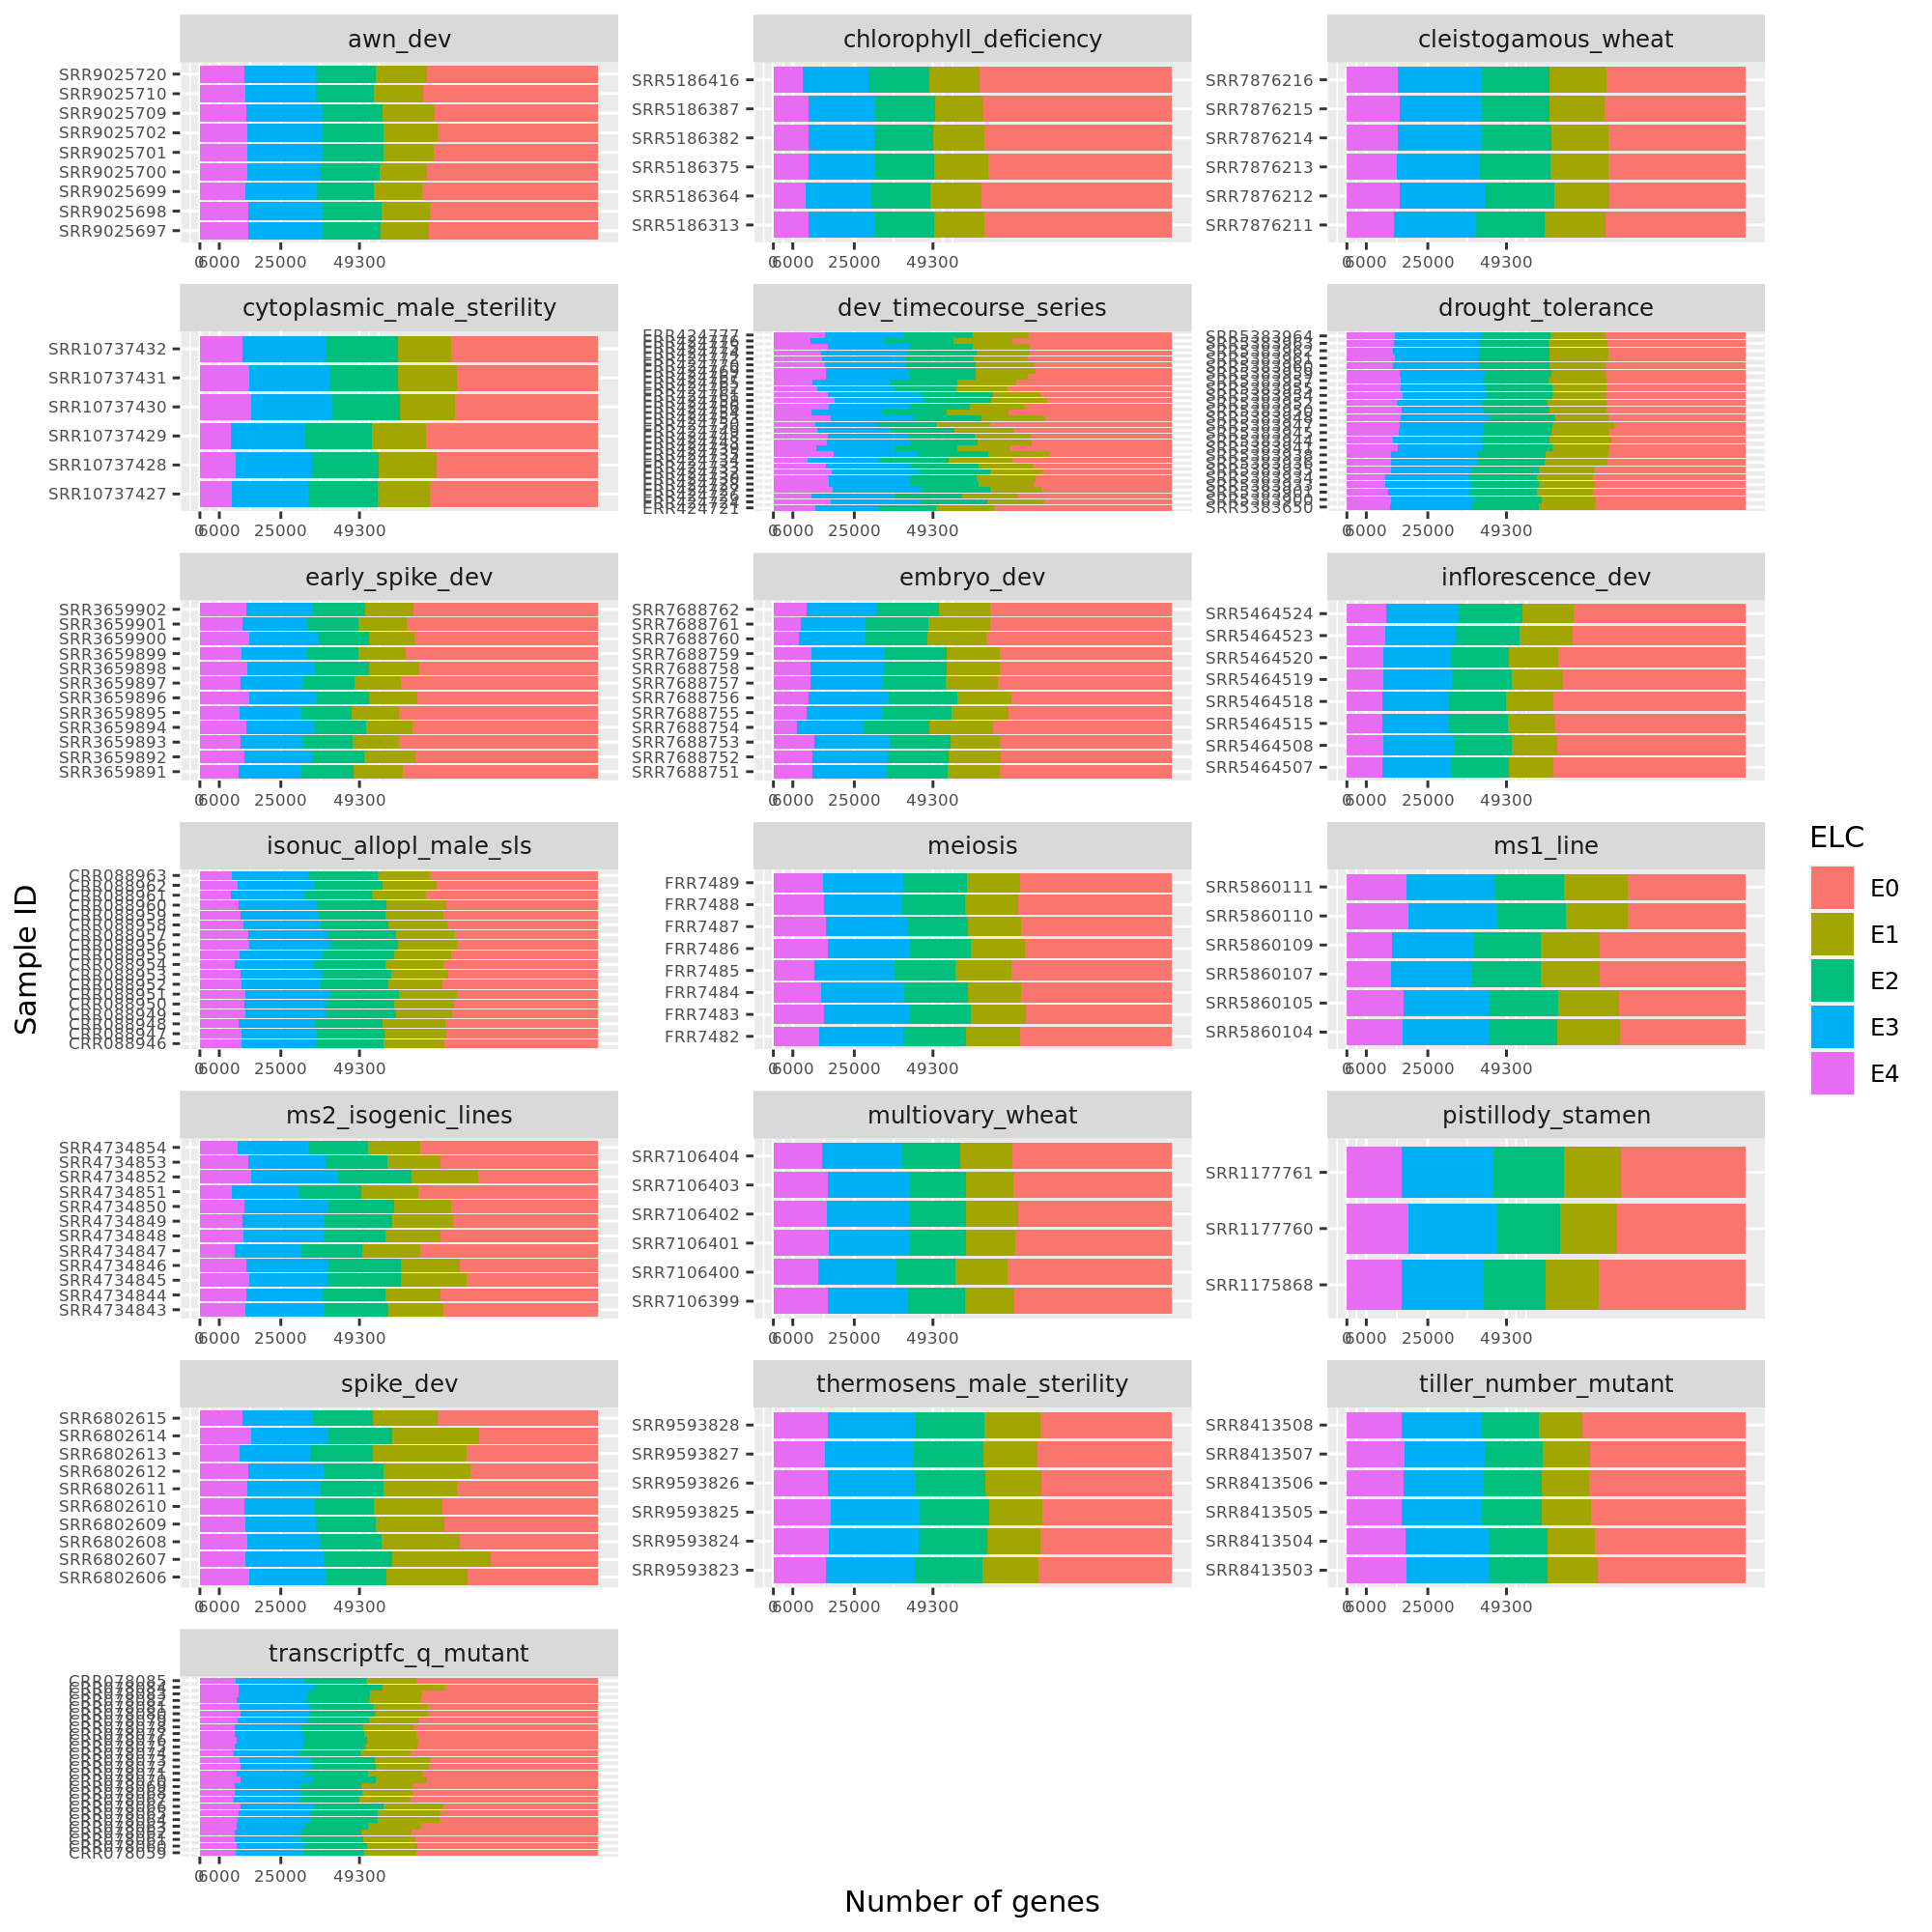

In [9]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)
# reverse = TRUE add to geom_col
elc_meta %>% 
    ggplot(aes(fill = ELC, y = ELC_value, x = sample)) +
        geom_col(position = "stack") +
        coord_flip() +
        labs(x = "Sample ID", y = "Number of genes") +
        scale_y_continuous(breaks =c(0, 6000, 25000, 49300)) +
        facet_wrap( ~ dataset, scales= "free", ncol = 3) +
        theme(axis.text = element_text(size=6))

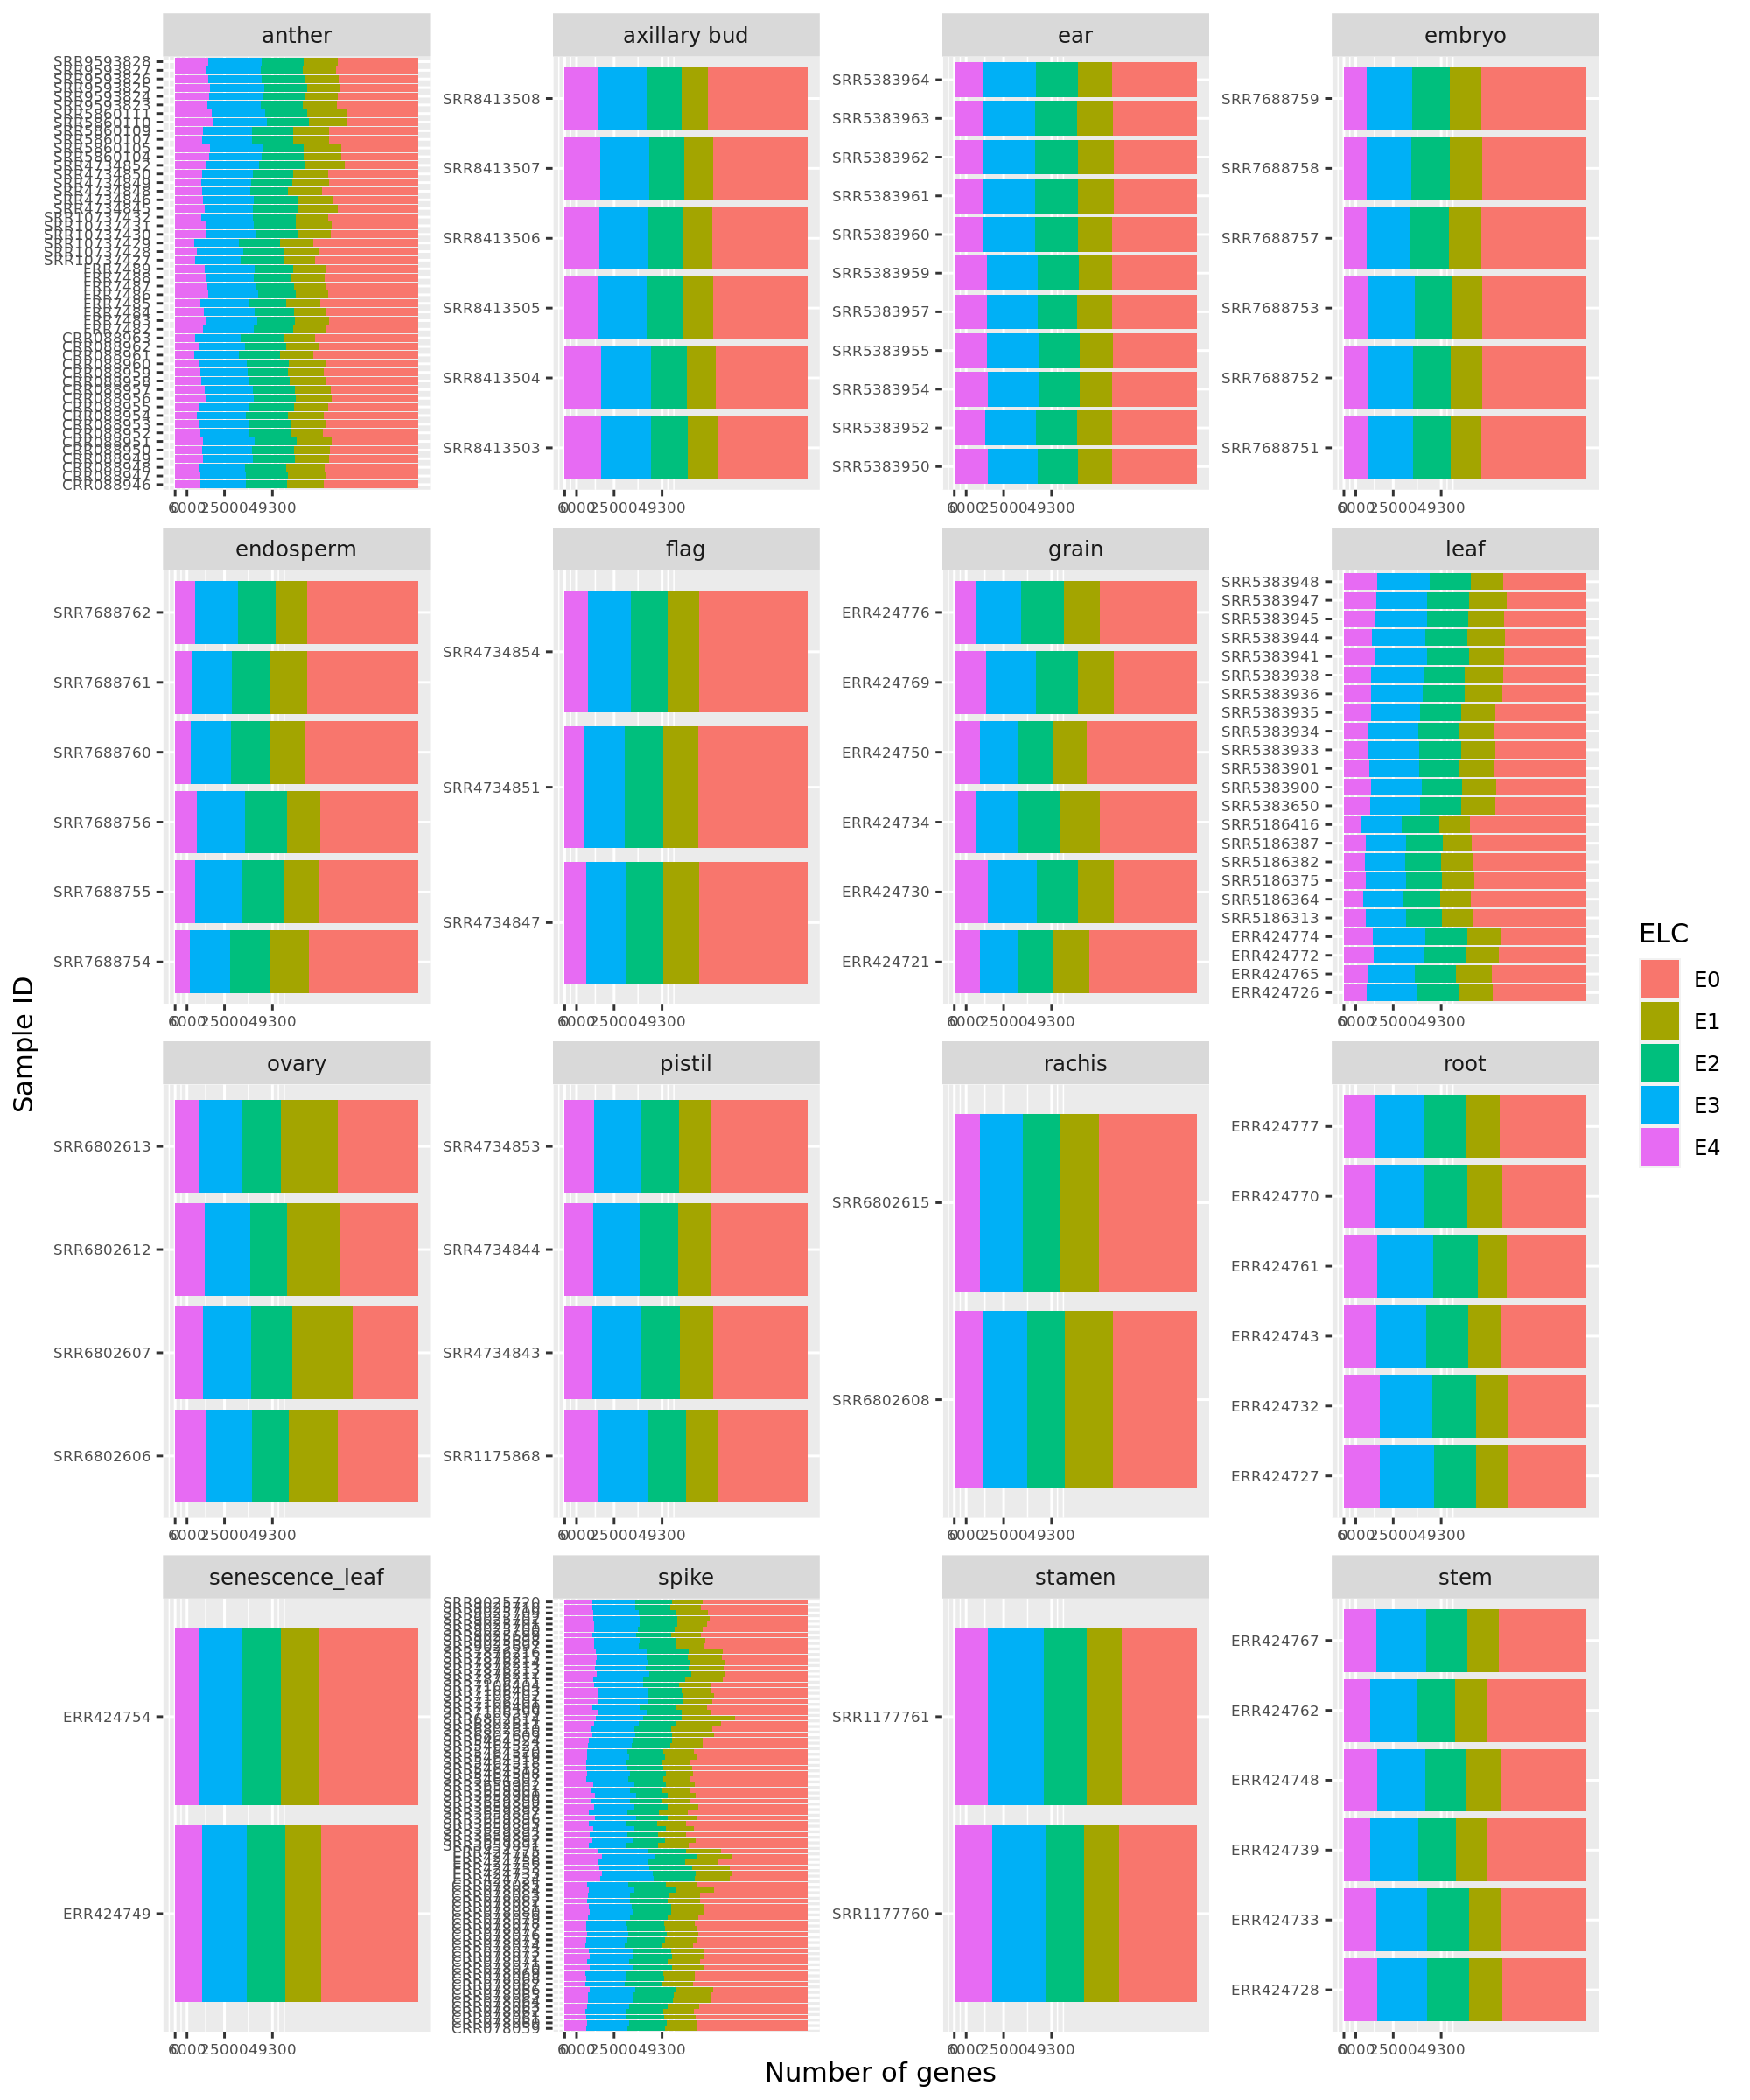

In [10]:
options(repr.plot.width = 10, repr.plot.height = 12, repr.plot.res = 200)

elc_meta %>% 
    ggplot(aes(fill = ELC, y = ELC_value, x = sample)) +
        geom_col(position = "stack") +
        coord_flip() +
        labs(x = "Sample ID", y = "Number of genes") +
        scale_y_continuous(breaks =c(0, 6000, 25000, 49300)) +
        facet_wrap( ~ intermediate_tissue, scales= "free", ncol = 4) +
        theme(axis.text = element_text(size=6))

# 2. ELC-analysis for PCA-s on non-normalised TPM counts


In [11]:
elc_pca <- elc %>% transmute(sample = sample, E0 = E0/total, E1 = E1/total, E2 = E2/total, E3 = E3/total, E4 = E4/total)
elc_pca_meta <- inner_join(elc_pca, wheat_meta_elc, by = "sample")
elc_pca_meta <- as.data.frame(elc_pca_meta, stringsAsFactors = TRUE)
rownames(elc_pca_meta) <- elc_pca_meta$sample
elc_pca_meta <- select(elc_pca_meta, -sample)
head(elc_pca_meta)

Warning message:
“Column `sample` joining character vector and factor, coercing into character vector”

,E0,E1,E2,E3,E4,dataset,batch,cultivar,gm,zadoc_scale,⋯,rna_enrichment,rna_input,pcr_purification,growth_condition,day_night,temp,growth_location,seq_location,instrument,library
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<int>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
CRR078059,0.4567053,0.1301808,0.1544505,0.1696770,0.08898639,transcriptfc_q_mutant,53,Bobwhite,wt,38,⋯,unknown,unknown,unknown,greenhouse,16_8,21,China,China,Illumina HiSeq 2000,single
CRR078060,0.4542677,0.1264270,0.1552224,0.1718464,0.09223644,transcriptfc_q_mutant,53,Bobwhite,wt,38,⋯,unknown,unknown,unknown,greenhouse,16_8,21,China,China,Illumina HiSeq 2000,single
CRR078061,0.4592484,0.1307495,0.1555474,0.1677595,0.08669510,transcriptfc_q_mutant,53,Bobwhite,wt,38,⋯,unknown,unknown,unknown,greenhouse,16_8,21,China,China,Illumina HiSeq 2000,single
CRR078062,0.4681292,0.1264107,0.1542312,0.1647857,0.08644323,transcriptfc_q_mutant,54,Bobwhite,wt,39,⋯,unknown,unknown,unknown,greenhouse,16_8,21,China,China,Illumina HiSeq 2000,single
CRR078063,0.4463538,0.1309852,0.1576925,0.1727158,0.09225269,transcriptfc_q_mutant,54,Bobwhite,wt,39,⋯,unknown,unknown,unknown,greenhouse,16_8,21,China,China,Illumina HiSeq 2000,single
CRR078064,0.3989681,0.1542880,0.1682876,0.1832460,0.09521024,transcriptfc_q_mutant,55,Bobwhite,wt,40,⋯,unknown,unknown,unknown,greenhouse,16_8,21,China,China,Illumina HiSeq 2000,single


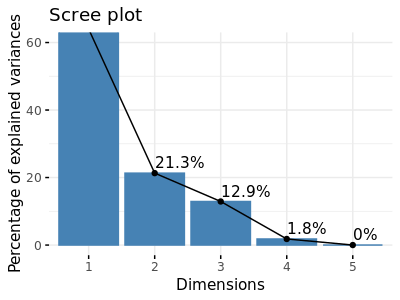

In [12]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 100)

elc_pca <- PCA(elc_pca_meta,quali.sup=6:26,graph=F)
fviz_screeplot(elc_pca, addlabels = TRUE, ylim = c(0, 60))

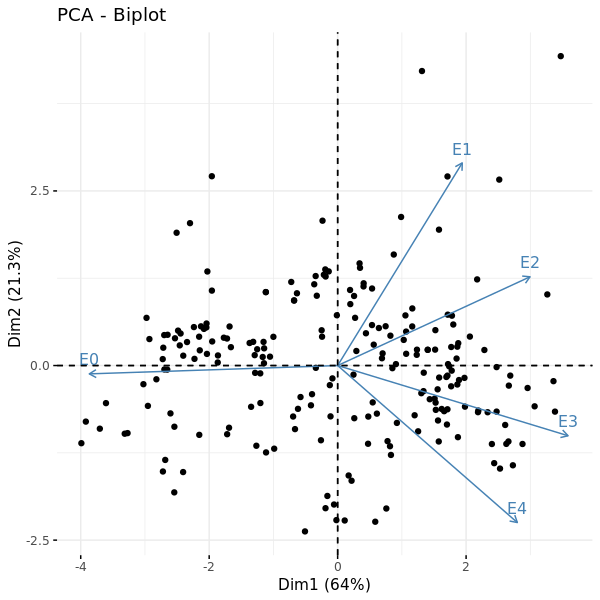

In [13]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_biplot(elc_pca, repel = FALSE,geom="point")

Too few points to calculate an ellipse
Too few points to calculate an ellipse


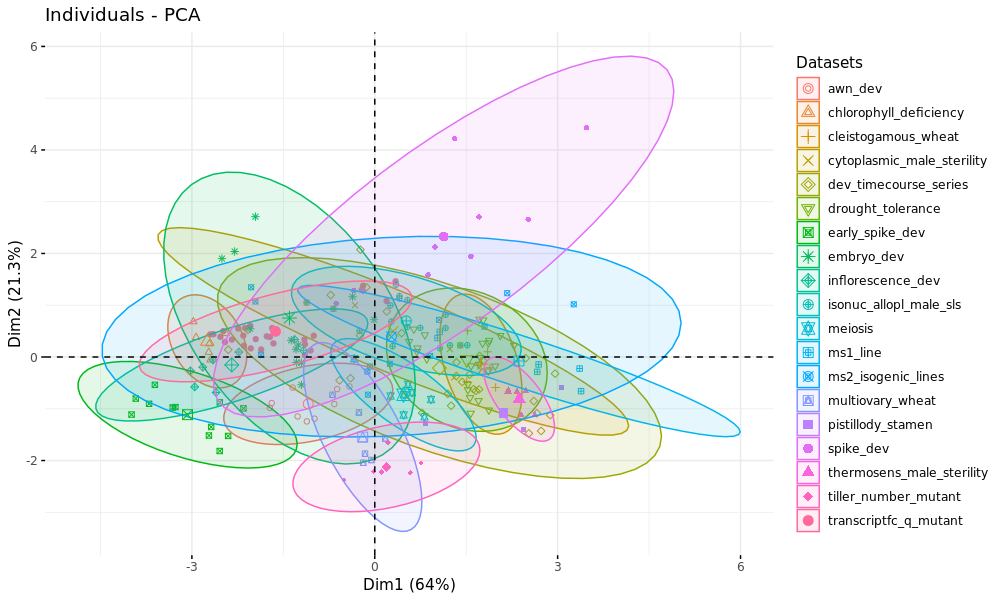

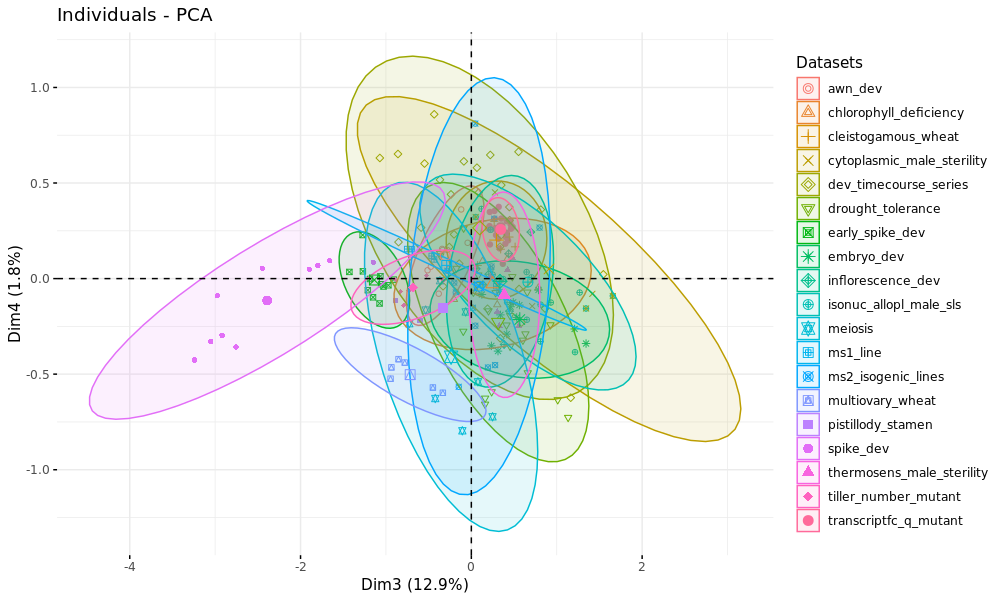

In [14]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(elc_pca, label = "none", habillage = elc_pca_meta$dataset, legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2))
fviz_pca_ind(elc_pca, label = "none", habillage = elc_pca_meta$dataset, legend.title = "Datasets", addEllipses = TRUE, axes = c(3, 4))

In [15]:
# build comparism plot variables
b1 <- fviz_pca_ind(X = elc_pca, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = elc_pca_meta$dataset)
b2 <- fviz_pca_ind(X = elc_pca, geom="point", axes = c(1, 2), legend.title = "Library type", habillage = elc_pca_meta$library)
b3 <- fviz_pca_ind(X = elc_pca, geom="point", axes = c(1, 2), legend.title = "Instrument", habillage = elc_pca_meta$instrument)
b4 <- fviz_pca_ind(X = elc_pca, geom="point", axes = c(1, 2), legend.title = "High level tissue", habillage = elc_pca_meta$high_level_tissue)
b5 <- fviz_pca_ind(X = elc_pca, geom="point", axes = c(1, 2), legend.title = "High level age", habillage = elc_pca_meta$high_level_age)
b6 <- fviz_pca_ind(X = elc_pca, geom="point", axes = c(1, 2), legend.title = "Intermediate tissue", habillage = elc_pca_meta$intermediate_tissue)

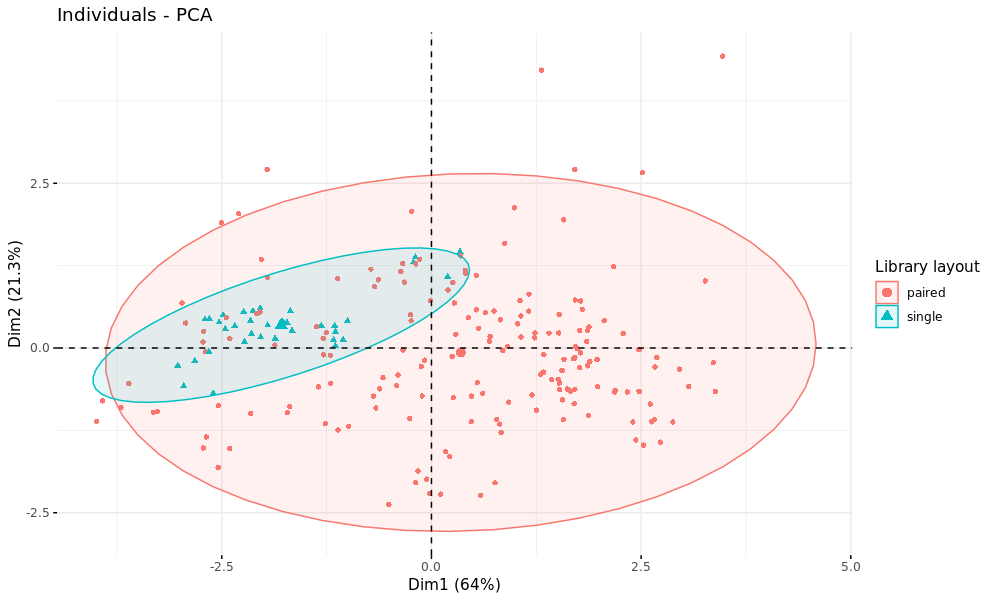

In [16]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(elc_pca, label = "none", habillage = elc_pca_meta$library, legend.title = "Library layout", addEllipses = TRUE, axes = c(1, 2))

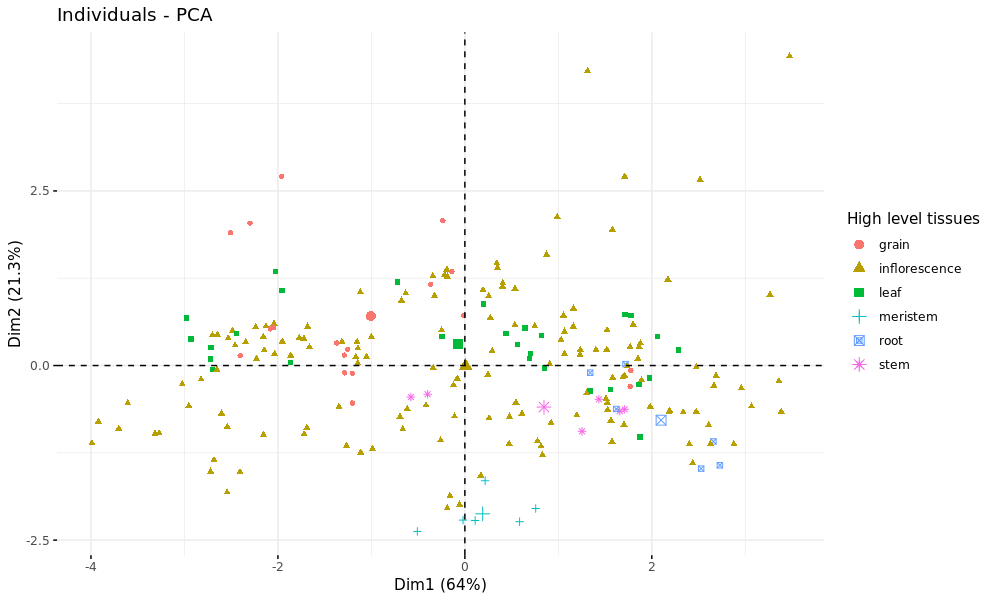

In [17]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(elc_pca, label = "none", habillage = elc_pca_meta$high_level_tissue, legend.title = "High level tissues", axes = c(1, 2))

,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5
E0,0.9888220,0.0009412639,0.01023422,2.495696e-06,9.591561e-31
E1,0.2488846,0.5564777773,0.19368627,9.513833e-04,1.266582e-31
E2,0.5933554,0.1067850359,0.27819121,2.166837e-02,6.005100e-32
E3,0.8510522,0.0668523394,0.03464352,4.745197e-02,1.279587e-31
E4,0.5175445,0.3341426347,0.12845160,1.986131e-02,1.488619e-31


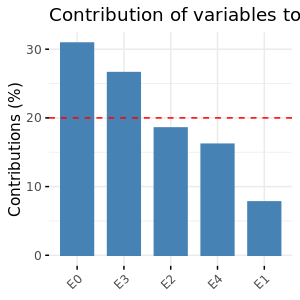

In [18]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 100)
get_pca_var(elc_pca)$cos2
fviz_contrib(elc_pca,"var",top=20,axis=1)

# 3. ELC-analysis for PCA-s on VS TPM counts


In [19]:
# import dds object from DESeq2 notebook
setwd("/nfs/pgsb/projects/comparative_triticeae/phenotype/flower_development/refsets/triticum/")
dds_wheat <- readRDS(file="dds_wheat.rds")
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 100)
plotDispEsts(dds_wheat)

Warning message in gzfile(file, "rb"):
“cannot open compressed file 'dds_wheat.rds', probable reason 'No such file or directory'”

ERROR: Error in gzfile(file, "rb"): cannot open the connection


In [ ]:
# this function gives log2 to raw counts
vsd_wheat <- varianceStabilizingTransformation(dds_wheat)
# this function returns matrix with log2transformed counts
vsdMat_wheat <- assay(vsd_wheat)

In [ ]:
non.expr.cutoff=0.5

get_elc=function(x,cut) {
    s=vsdMat_wheat
    sx=x[x>cut]
    k=kmeans(log(sx+cut),4)
    kk=ordered(k$cluster,levels=order(k$centers))
    levels(kk)=paste("E",1:4,sep="")
    so=ordered(rep("E0",nrow(s)),levels=paste("E",0:4,sep=""))
    so[x>cut]=kk
    so
}
vs_elc=apply(vsdMat_wheat,2,get_elc,non.expr.cutoff)
colnames(vs_elc)=colnames(vsdMat_wheat)
rownames(vs_elc)=rownames(vsdMat_wheat)
head(vs_elc)

In [ ]:
colnames(wheat_meta) <- c("ID", "dataset", "batch", "cultivar", "gm", "zadoc_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")

vs_df <- as.data.frame(vs_elc, stringsAsFactors = FALSE)
vs_df <- pivot_longer(vs_df, cols = c(1:240), names_to = "ID", values_to = "ELC")

elc_vs <- vs_df %>% select(ID, ELC) %>%
                dplyr::group_by(ID) %>%
                dplyr::summarise(total = n(), E0 = sum(ELC=="E0"), E1 = sum(ELC=="E1"), E2 = sum(ELC=="E2"), E3 = sum(ELC=="E3"), E4 = sum(ELC=="E4"))
vs_elc_pca <- elc_vs %>% transmute(ID = ID, E0 = E0/total, E1 = E1/total, E2 = E2/total, E3 = E3/total, E4 = E4/total)
vs_elc_pca_meta <- inner_join(vs_elc_pca, wheat_meta, by = "ID")
vs_elc_pca_meta <- as.data.frame(vs_elc_pca_meta, stringsAsFactors = TRUE)
rownames(vs_elc_pca_meta) <- vs_elc_pca_meta$ID
vs_elc_pca_meta <- select(vs_elc_pca_meta, -ID)
head(vs_elc_pca_meta)
dim(vs_elc_pca_meta)

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 100)

vs_elc_pca <- PCA(vs_elc_pca_meta,quali.sup=c(6:26),graph=F)
fviz_screeplot(vs_elc_pca, addlabels = TRUE)

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_biplot(vs_elc_pca, repel = FALSE,geom="point")

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(vs_elc_pca, label = "none", habillage = vs_elc_pca_meta$dataset, legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2))
fviz_pca_ind(vs_elc_pca, label = "none", habillage = vs_elc_pca_meta$dataset, legend.title = "Datasets", addEllipses = TRUE, axes = c(3, 4))

In [ ]:
# build comparism plot variables
d1 <- fviz_pca_ind(X = vs_elc_pca, label = "none", legend.title = "Datasets", addEllipses = TRUE, axes = c(1, 2), habillage = vs_elc_pca_meta$dataset)
d2 <- fviz_pca_ind(X = vs_elc_pca, geom="point", axes = c(1, 2), legend.title = "Library type", habillage = vs_elc_pca_meta$library)
d3 <- fviz_pca_ind(X = vs_elc_pca, geom="point", axes = c(1, 2), legend.title = "Instrument", habillage = vs_elc_pca_meta$instrument)
d4 <- fviz_pca_ind(X = vs_elc_pca, geom="point", axes = c(1, 2), legend.title = "High level tissue", habillage = vs_elc_pca_meta$high_level_tissue)
d5 <- fviz_pca_ind(X = vs_elc_pca, geom="point", axes = c(1, 2), legend.title = "High level age", habillage = vs_elc_pca_meta$high_level_age)
d6 <- fviz_pca_ind(X = vs_elc_pca, geom="point", axes = c(1, 2), legend.title = "Intermediate tissue", habillage = vs_elc_pca_meta$intermediate_tissue)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(vs_elc_pca, label = "none", habillage = vs_elc_pca_meta$library, legend.title = "Library layout", addEllipses = TRUE, axes = c(1, 2))

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)
fviz_pca_ind(vs_elc_pca, label = "none", habillage = vs_elc_pca_meta$high_level_tissue, legend.title = "High level tissues", axes = c(1, 2))

In [ ]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 100)
get_pca_var(vs_elc_pca)$cos2
fviz_contrib(vs_elc_pca,"var",top=20,axis=1)

## 3.1 Summarizing comparism figures

In [ ]:
# figure about why variance stabilization is necessary
setwd("/home/vanda.marosi/floral_development_thesis_vm/figures/")
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 300)

prow1 <- plot_grid(b1 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d1 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend1 <- get_legend(b1 + theme(legend.box.margin = margin(0, 0, 0, 12)))

prow2 <- plot_grid(b2 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d2 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend2 <- get_legend(b2 + theme(legend.box.margin = margin(0, 0, 0, 12)))

prow3 <- plot_grid(b3 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d3 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend3 <- get_legend(b3 + theme(legend.box.margin = margin(0, 0, 0, 12)))

prow4 <- plot_grid(b4 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d4 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend4 <- get_legend(b4 + theme(legend.box.margin = margin(0, 0, 0, 12)))

prow5 <- plot_grid(b5 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d5 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend5 <- get_legend(b5 + theme(legend.box.margin = margin(0, 0, 0, 12)))

prow6 <- plot_grid(b6 + ggtitle("ELC before VS") + theme(legend.position="none"), 
                  d6 + ggtitle("ELC after VS") + theme(legend.position="none"), 
                   align = 'vh', hjust = -1, nrow = 1)
legend6 <- get_legend(b6 + theme(legend.box.margin = margin(0, 0, 0, 12), legend.position = "bottom"))
# to save as a png
#png("stabilized_counts.png", units="in", width=10, height=4, res=300)
#cowplot::plot_grid(p1$gg + ggtitle("TPM") + scale_x_continuous(breaks =c(0, 25000, 75000, 125000)), p2$gg + ggtitle("log10(TPM)"), p3$gg + ggtitle("Variance Stabilized counts"), ncol = 3)
#dev.off()

In [ ]:
cowplot::plot_grid(prow1, legend1, rel_widths = c(3, .8))
cowplot::plot_grid(prow2, legend2, rel_widths = c(3, .4))
cowplot::plot_grid(prow3, legend3, rel_widths = c(3, .7))
cowplot::plot_grid(prow4, legend4, rel_widths = c(3, .5))
cowplot::plot_grid(prow5, legend5, rel_widths = c(3, .5))
cowplot::plot_grid(prow6, legend6, ncol = 1, rel_heights = c(1, .3))

# 4. Calculating expression bias
* dividing the # of E4 samples with library size

In [19]:
head(h)
d <- as.data.frame(h)
#d$locus <- row.names(d)
locus <- rownames(d)
rownames(d) <- NULL
d <- cbind(locus,d)
head(d)

,SRR10737427,SRR10737428,SRR10737429,SRR10737430,SRR10737431,SRR10737432,CRR088963,CRR088962,CRR088961,CRR088960,⋯,SRR8413505,SRR8413506,SRR8413507,SRR8413508,SRR5186313,SRR5186364,SRR5186375,SRR5186382,SRR5186387,SRR5186416
TraesCHI1A01G000100,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0000,⋯,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TraesCHI1A01G000200,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0000,⋯,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TraesCHI1A01G000300,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0000,⋯,6.0000,7.878112,14.0000,1.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TraesCHI1A01G000400,0.0000,0.000000,0.0000,4.893036,4.726423,1.938802,0.0000,0.000000,0.0000,0.0000,⋯,140.5432,108.839845,177.3651,112.3966,1.993108,0.000000,0.000000,0.000000,2.004102,0.000000
TraesCHI1A01G000500,1.0000,8.000000,7.0000,9.000000,2.000000,3.000000,1.0000,8.000000,7.0000,9.0000,⋯,5.0000,11.000000,12.0000,5.0000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000
TraesCHI1A01G000600,193.3952,2.465932,159.4838,51.088736,8.853329,80.785644,193.3877,2.465675,159.5168,126.3058,⋯,387.2507,513.135328,458.2691,355.3096,0.000000,2.649372,1.307648,4.297154,4.083578,1.356089


,locus,SRR10737427,SRR10737428,SRR10737429,SRR10737430,SRR10737431,SRR10737432,CRR088963,CRR088962,CRR088961,⋯,SRR8413505,SRR8413506,SRR8413507,SRR8413508,SRR5186313,SRR5186364,SRR5186375,SRR5186382,SRR5186387,SRR5186416
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TraesCHI1A01G000100,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,⋯,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,TraesCHI1A01G000200,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,⋯,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,TraesCHI1A01G000300,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,⋯,6.0000,7.878112,14.0000,1.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TraesCHI1A01G000400,0.0000,0.000000,0.0000,4.893036,4.726423,1.938802,0.0000,0.000000,0.0000,⋯,140.5432,108.839845,177.3651,112.3966,1.993108,0.000000,0.000000,0.000000,2.004102,0.000000
5,TraesCHI1A01G000500,1.0000,8.000000,7.0000,9.000000,2.000000,3.000000,1.0000,8.000000,7.0000,⋯,5.0000,11.000000,12.0000,5.0000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000
6,TraesCHI1A01G000600,193.3952,2.465932,159.4838,51.088736,8.853329,80.785644,193.3877,2.465675,159.5168,⋯,387.2507,513.135328,458.2691,355.3096,0.000000,2.649372,1.307648,4.297154,4.083578,1.356089


In [20]:
m=as.data.table(d)
m=melt(m,id.vars=c("locus"),variable.name="sample_id",value.name="tpm")
setkey(m,locus,sample_id)
head(m)

locus,sample_id,tpm
<fct>,<fct>,<dbl>
TraesCHI1A01G000100,SRR10737427,0
TraesCHI1A01G000100,SRR10737428,0
TraesCHI1A01G000100,SRR10737429,0
TraesCHI1A01G000100,SRR10737430,0
TraesCHI1A01G000100,SRR10737431,0
TraesCHI1A01G000100,SRR10737432,0


In [21]:
tau<-function(x){
  if(any(is.na(x))) stop('NA\'s need to be 0.')
  if(any(x<0)) stop('Negative input values not permitted. Maybe data is log transformed?')
  t<-sum(1-x/max(x))/(length(x)-1)
} 

In [22]:
dm <- data.matrix(d, rownames.force = TRUE)
locus <- d$locus
row.names(dm) <- locus
dm <- dm[1:123075, 2:215]
head(dm)
tau=apply(dm,1,tau)
head(tau)

,SRR10737427,SRR10737428,SRR10737429,SRR10737430,SRR10737431,SRR10737432,CRR088963,CRR088962,CRR088961,CRR088960,⋯,SRR8413504,SRR8413505,SRR8413506,SRR8413507,SRR8413508,SRR5186313,SRR5186364,SRR5186375,SRR5186382,SRR5186387
TraesCHI1A01G000100,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0000,⋯,0.0000,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
TraesCHI1A01G000200,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0000,⋯,0.0000,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
TraesCHI1A01G000300,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0000,⋯,12.0000,6.0000,7.878112,14.0000,1.0000,0.000000,0.000000,0.000000,0.000000,0.000000
TraesCHI1A01G000400,0.0000,0.000000,0.0000,4.893036,4.726423,1.938802,0.0000,0.000000,0.0000,0.0000,⋯,165.4823,140.5432,108.839845,177.3651,112.3966,1.993108,0.000000,0.000000,0.000000,2.004102
TraesCHI1A01G000500,1.0000,8.000000,7.0000,9.000000,2.000000,3.000000,1.0000,8.000000,7.0000,9.0000,⋯,2.0000,5.0000,11.000000,12.0000,5.0000,1.000000,0.000000,2.000000,0.000000,0.000000
TraesCHI1A01G000600,193.3952,2.465932,159.4838,51.088736,8.853329,80.785644,193.3877,2.465675,159.5168,126.3058,⋯,235.6229,387.2507,513.135328,458.2691,355.3096,0.000000,2.649372,1.307648,4.297154,4.083578


TraesCHI1A01G000100 TraesCHI1A01G000200 TraesCHI1A01G000300 TraesCHI1A01G000400 
          0.8802601           0.9621416           0.9404657           0.8947432 
TraesCHI1A01G000500 TraesCHI1A01G000600 
          0.9556996           0.9657680

In [23]:
Mall = m[,list(sample=sample_id, tpm=tpm, min_tpm=min(tpm,na.rm=TRUE),median_tpm=median(tpm,na.rm=TRUE),max_tpm=max(tpm,na.rm=TRUE),breadth=length(tpm[tpm>non.expr.cutoff])/length(tpm)),by=list(locus)]
Mall = data.table(sample=Mall$sample, locus=Mall$locus, tpm=Mall$tpm, min_tpm=Mall$min_tpm, median_tpm=Mall$median_tpm, max_tpm=Mall$max_tpm, breadth=Mall$breadth)
setkey(Mall,sample)
head(Mall)

sample,locus,tpm,min_tpm,median_tpm,max_tpm,breadth
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SRR10737427,TraesCHI1A01G000100,0.0000,0,16.686023,2184.2529,0.5488372
SRR10737427,TraesCHI1A01G000200,0.0000,0,0.000000,47.0000,0.2279070
SRR10737427,TraesCHI1A01G000300,0.0000,0,1.000000,271.9947,0.5534884
SRR10737427,TraesCHI1A01G000400,0.0000,0,23.554188,567.1340,0.8883721
SRR10737427,TraesCHI1A01G000500,1.0000,0,2.042307,205.0000,0.7023256
SRR10737427,TraesCHI1A01G000600,193.3952,0,1.468808,683.8116,0.5395349


In [24]:
tau=as.data.table(data.frame(locus=names(tau),tau=tau))
setkey(tau,locus)
head(tau)

locus,tau
<fct>,<dbl>
TraesCHI1A01G000100,0.8802601
TraesCHI1A01G000200,0.9621416
TraesCHI1A01G000300,0.9404657
TraesCHI1A01G000400,0.8947432
TraesCHI1A01G000500,0.9556996
TraesCHI1A01G000600,0.9657680


In [25]:
Mall=merge(Mall,tau, by = "locus")
setkey(Mall, locus)
head(Mall)
nrow(Mall)

locus,sample,tpm,min_tpm,median_tpm,max_tpm,breadth,tau
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TraesCHI1A01G000100,SRR10737427,0,0,16.68602,2184.253,0.5488372,0.8802601
TraesCHI1A01G000100,SRR10737428,0,0,16.68602,2184.253,0.5488372,0.8802601
TraesCHI1A01G000100,SRR10737429,0,0,16.68602,2184.253,0.5488372,0.8802601
TraesCHI1A01G000100,SRR10737430,0,0,16.68602,2184.253,0.5488372,0.8802601
TraesCHI1A01G000100,SRR10737431,0,0,16.68602,2184.253,0.5488372,0.8802601
TraesCHI1A01G000100,SRR10737432,0,0,16.68602,2184.253,0.5488372,0.8802601


[1] 26461125

In [26]:
get_elc=function(cut,f,n) {
    s=Mall
    sx=s[s[[f]]>cut]
    k=kmeans(log(sx[,f,with=FALSE]+cut),4)
    kk=ordered(k$cluster,levels=order(k$centers))
    levels(kk)=paste("E",1:4,sep="")
    so=ordered(rep("E0",nrow(s)),levels=paste("E",0:4,sep=""))
    so[s[[f]]>cut]=kk
    so=data.frame(o=so)
    names(so)[ncol(so)]=gsub("tpm","elc",n)
    so=as.data.table(so)
    so
}

In [27]:
MO=foreach(i=3:6,.combine="cbind") %do% {
    get_elc(non.expr.cutoff,i,names(Mall)[i])
}
MO=cbind(Mall,MO)
setkey(MO,sample)

In [28]:
MO[,blc:=cut(breadth,breaks=seq(0,1,0.2,),include.lowest=TRUE,ordered.result=TRUE,labels=c("very few","few","medium","many","most")),by=list(locus)] 

In [29]:
head(MO) 

locus,sample,tpm,min_tpm,median_tpm,max_tpm,breadth,tau,elc,min_elc,median_elc,max_elc,blc
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<ord>,<ord>,<ord>,<fct>
TraesCHI1A01G000100,SRR10737427,0.0000,0,16.686023,2184.2529,0.5488372,0.8802601,E0,E0,E2,E4,medium
TraesCHI1A01G000200,SRR10737427,0.0000,0,0.000000,47.0000,0.2279070,0.9621416,E0,E0,E0,E2,few
TraesCHI1A01G000300,SRR10737427,0.0000,0,1.000000,271.9947,0.5534884,0.9404657,E0,E0,E1,E3,medium
TraesCHI1A01G000400,SRR10737427,0.0000,0,23.554188,567.1340,0.8883721,0.8947432,E0,E0,E2,E3,most
TraesCHI1A01G000500,SRR10737427,1.0000,0,2.042307,205.0000,0.7023256,0.9556996,E1,E0,E1,E2,many
TraesCHI1A01G000600,SRR10737427,193.3952,0,1.468808,683.8116,0.5395349,0.9657680,E3,E0,E1,E3,medium


In [30]:
bias <- select(MO, locus, sample, tpm, elc)
glimpse(bias)

Rows: 26,461,125
Columns: 4
$ locus  <fct> TraesCHI1A01G000100, TraesCHI1A01G000200, TraesCHI1A01G000300,…
$ sample <fct> SRR10737427, SRR10737427, SRR10737427, SRR10737427, SRR1073742…
$ tpm    <dbl> 0.000000, 0.000000, 0.000000, 0.000000, 1.000000, 193.395199, …
$ elc    <ord> E0, E0, E0, E0, E1, E3, E3, E2, E4, E3, E2, E1, E2, E3, E4, E2…


In [31]:
bias_sum <- bias %>% filter(elc == "E4") %>%
        group_by(sample) %>%
        summarise(E4_tpm_sum = sum(tpm))
#bias_sum$E4_tpm_sum <- as.integer(bias_sum$E4_tpm_sum)
#bias_sum$sample <- as.character(bias_sum$sample)


lib_size <- bias %>% group_by(sample) %>%
        summarise(lib_size = sum(tpm))
#lib_size$lib_size <- as.integer(lib_size$lib_size)
#lib_size$sample <- as.character(lib_size$sample)

bias_lib <- inner_join(bias_sum, lib_size, by ="sample") 

setwd("/home/vanda.marosi/floral_development_thesis_vm/datatables/")
wheat_metadata <- read.table("wheat_final.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)
wheat_meta <- select(wheat_metadata, Run.ID, Dataset, Batch, Cultivar, GM, Zadok_scale, Intermediate_age, High_level_age, Intermediate_tissue, High_level_tissue, Treatment, RNA_extraction, RNA_enrichment, RNA_input..microg., PCR_purification, Growth_condition, Day_night_condition, Temperature_day_night_c, Growth_location, Seq_location, Instrument, Library.layout)
colnames(wheat_meta) <- c("sample", "dataset", "batch", "cultivar", "gm", "zadoc_scale", "intermediate_age", "high_level_age", "intermediate_tissue", "high_level_tissue", "treatment", "rna_extraction", "rna_enrichment", "rna_input", "pcr_purification", "growth_condition", "day_night", "temp", "growth_location", "seq_location", "instrument", "library")

bias_lib <- inner_join(bias_lib, wheat_meta, by = "sample")
expr_bias <- bias_lib %>% mutate(bias = E4_tpm_sum/lib_size)
# next lines were made for boxplot display
#expr_bias <- bias_lib %>% mutate(bias = ((E4_tpm_sum/lib_size)*100))
#expr_bias$bias <- as.integer(expr_bias$bias)

glimpse(bias_sum)
glimpse(lib_size)
glimpse(expr_bias)

Warning message:
“Column `sample` joining factor and character vector, coercing into character vector”

Rows: 215
Columns: 2
$ sample     <fct> SRR10737427, SRR10737428, SRR10737429, SRR10737430, SRR107…
$ E4_tpm_sum <dbl> 9122546, 9513476, 5967099, 9857947, 8762122, 9779950, 9122…
Rows: 215
Columns: 2
$ sample   <fct> SRR10737427, SRR10737428, SRR10737429, SRR10737430, SRR10737…
$ lib_size <dbl> 12548905, 13487925, 9197070, 14286156, 13293828, 14068842, 1…
Rows: 215
Columns: 25
$ sample              <chr> "SRR10737427", "SRR10737428", "SRR10737429", "SRR…
$ E4_tpm_sum          <dbl> 9122546, 9513476, 5967099, 9857947, 8762122, 9779…
$ lib_size            <dbl> 12548905, 13487925, 9197070, 14286156, 13293828, …
$ dataset             <chr> "cytoplasmic_male_sterility", "cytoplasmic_male_s…
$ batch               <int> 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6…
$ cultivar            <chr> "303-B", "303-B", "303-B", "C303A", "C303A", "C30…
$ gm                  <chr> "wt", "wt", "wt", "mut", "mut", "mut", "wt", "wt"…
$ zadoc_scale         <int> 56, 56, 56, 56, 56, 56, 56, 56, 56, 56,

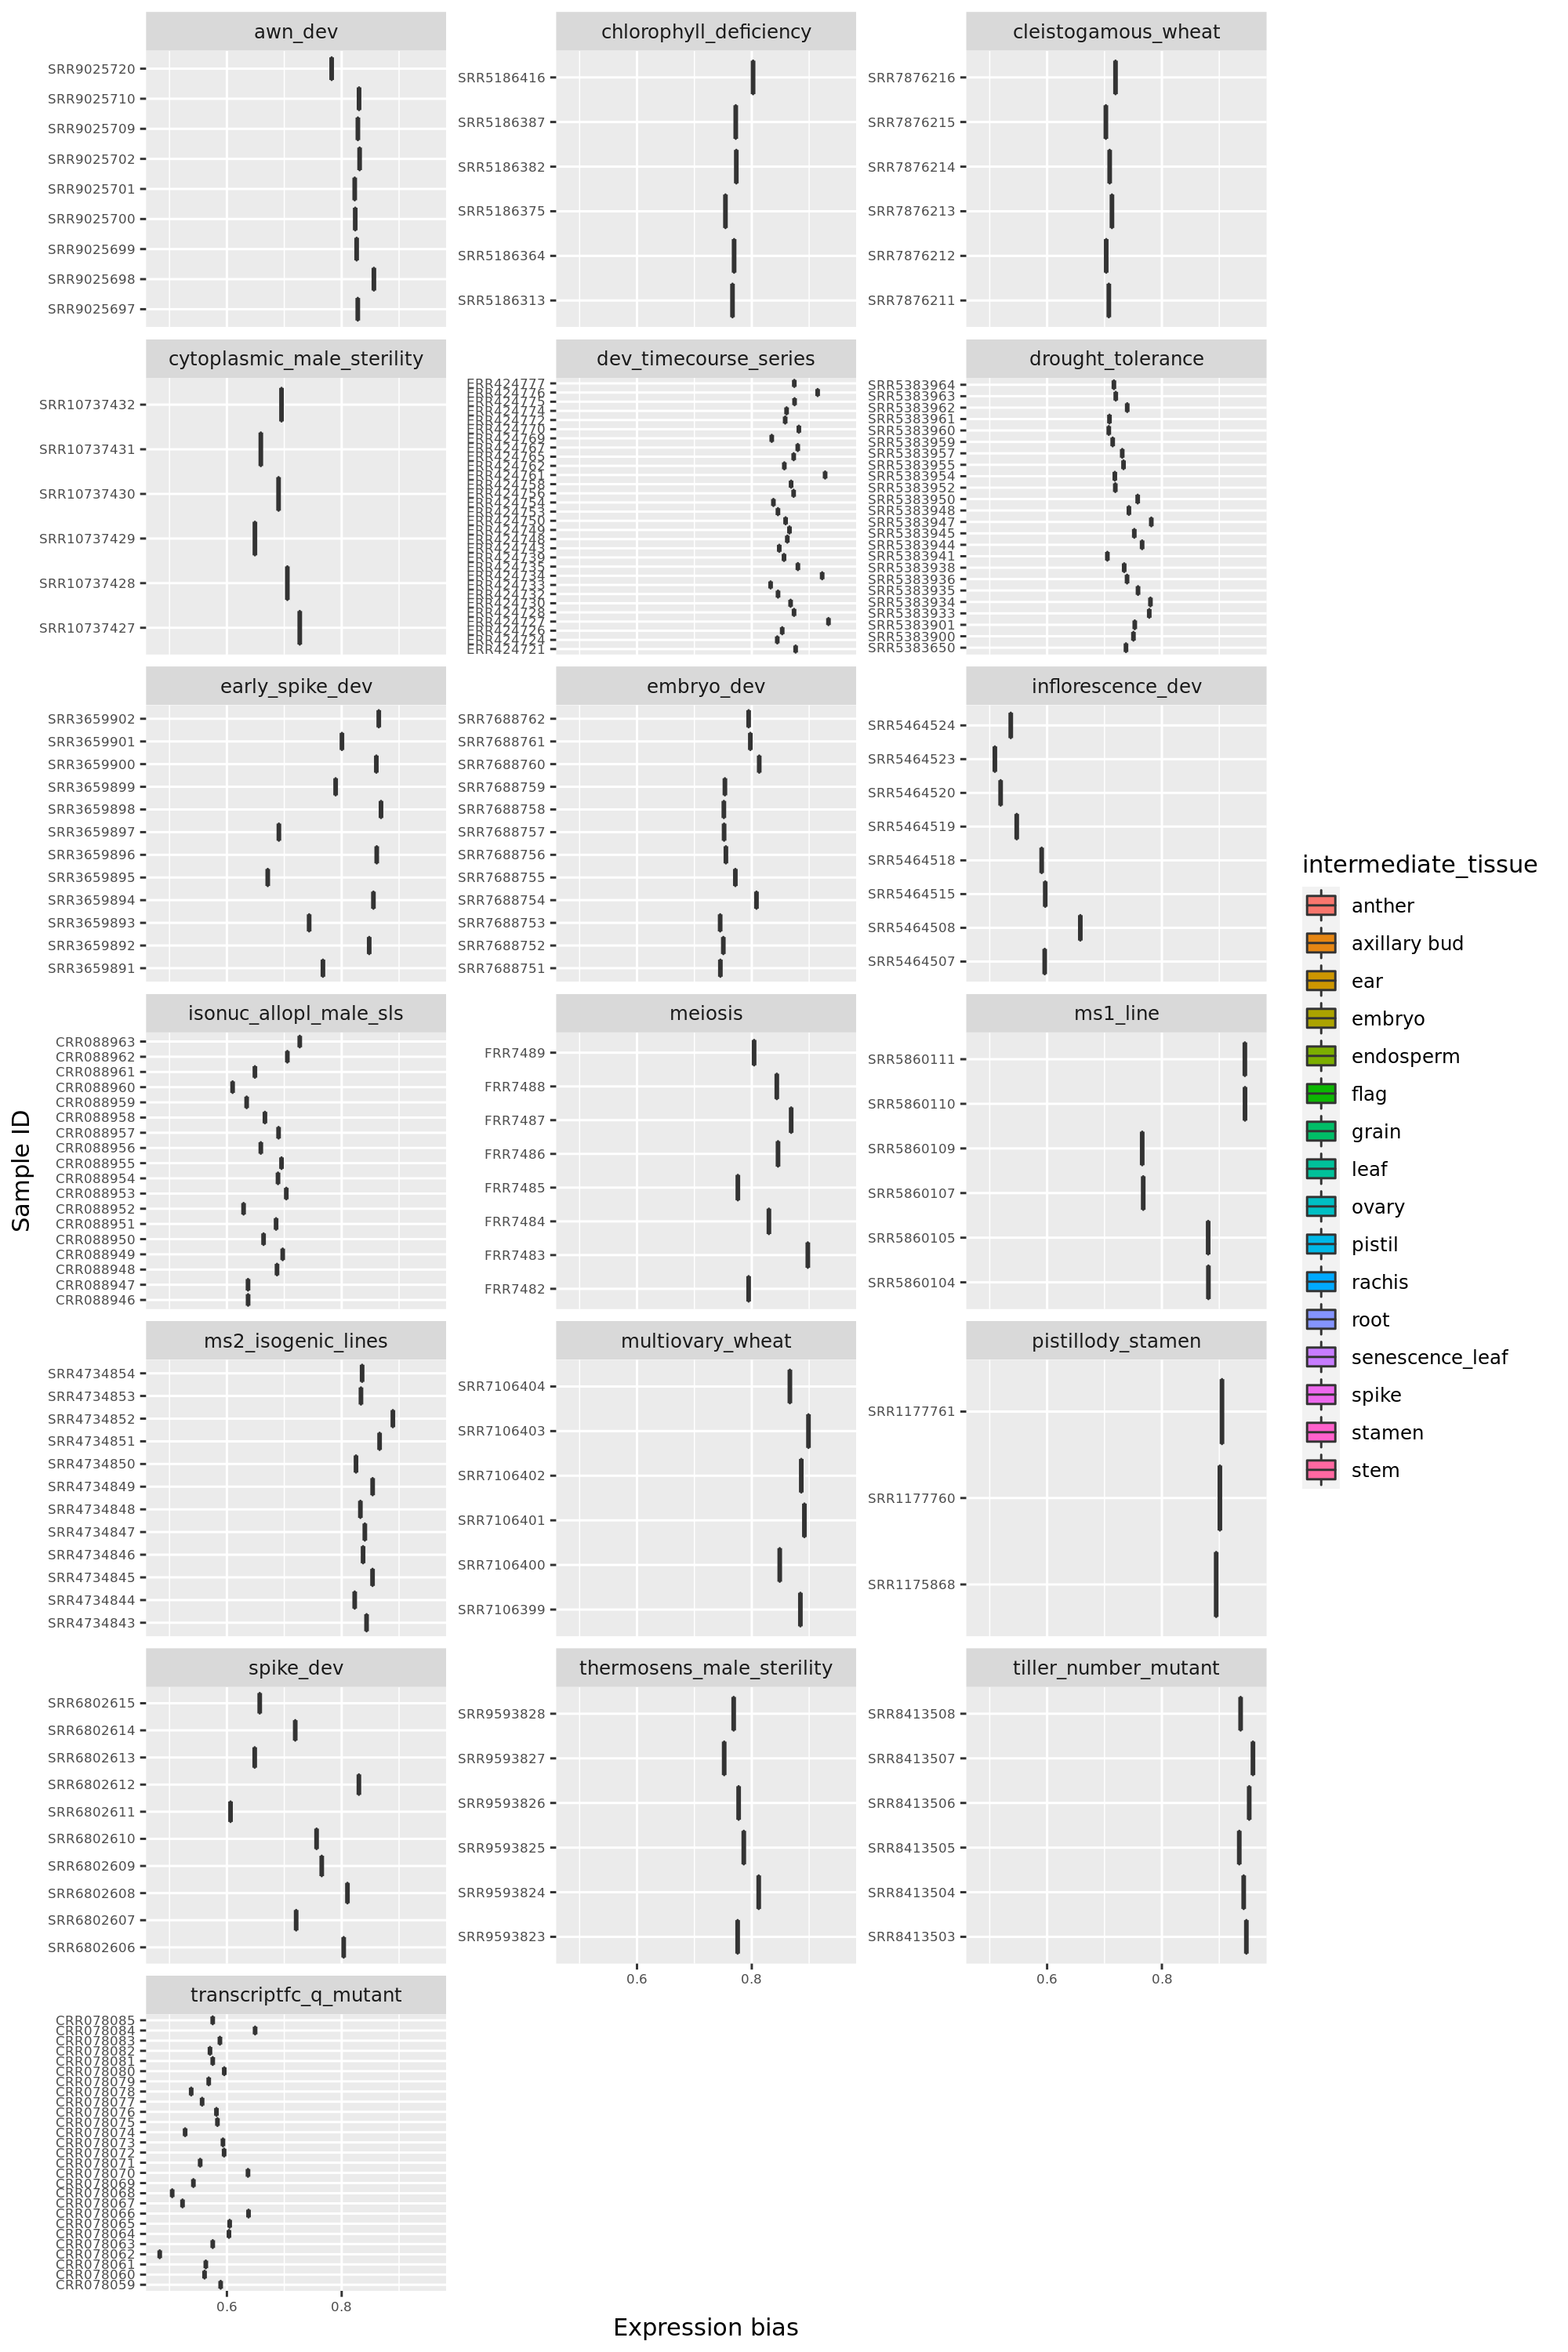

png 
  2

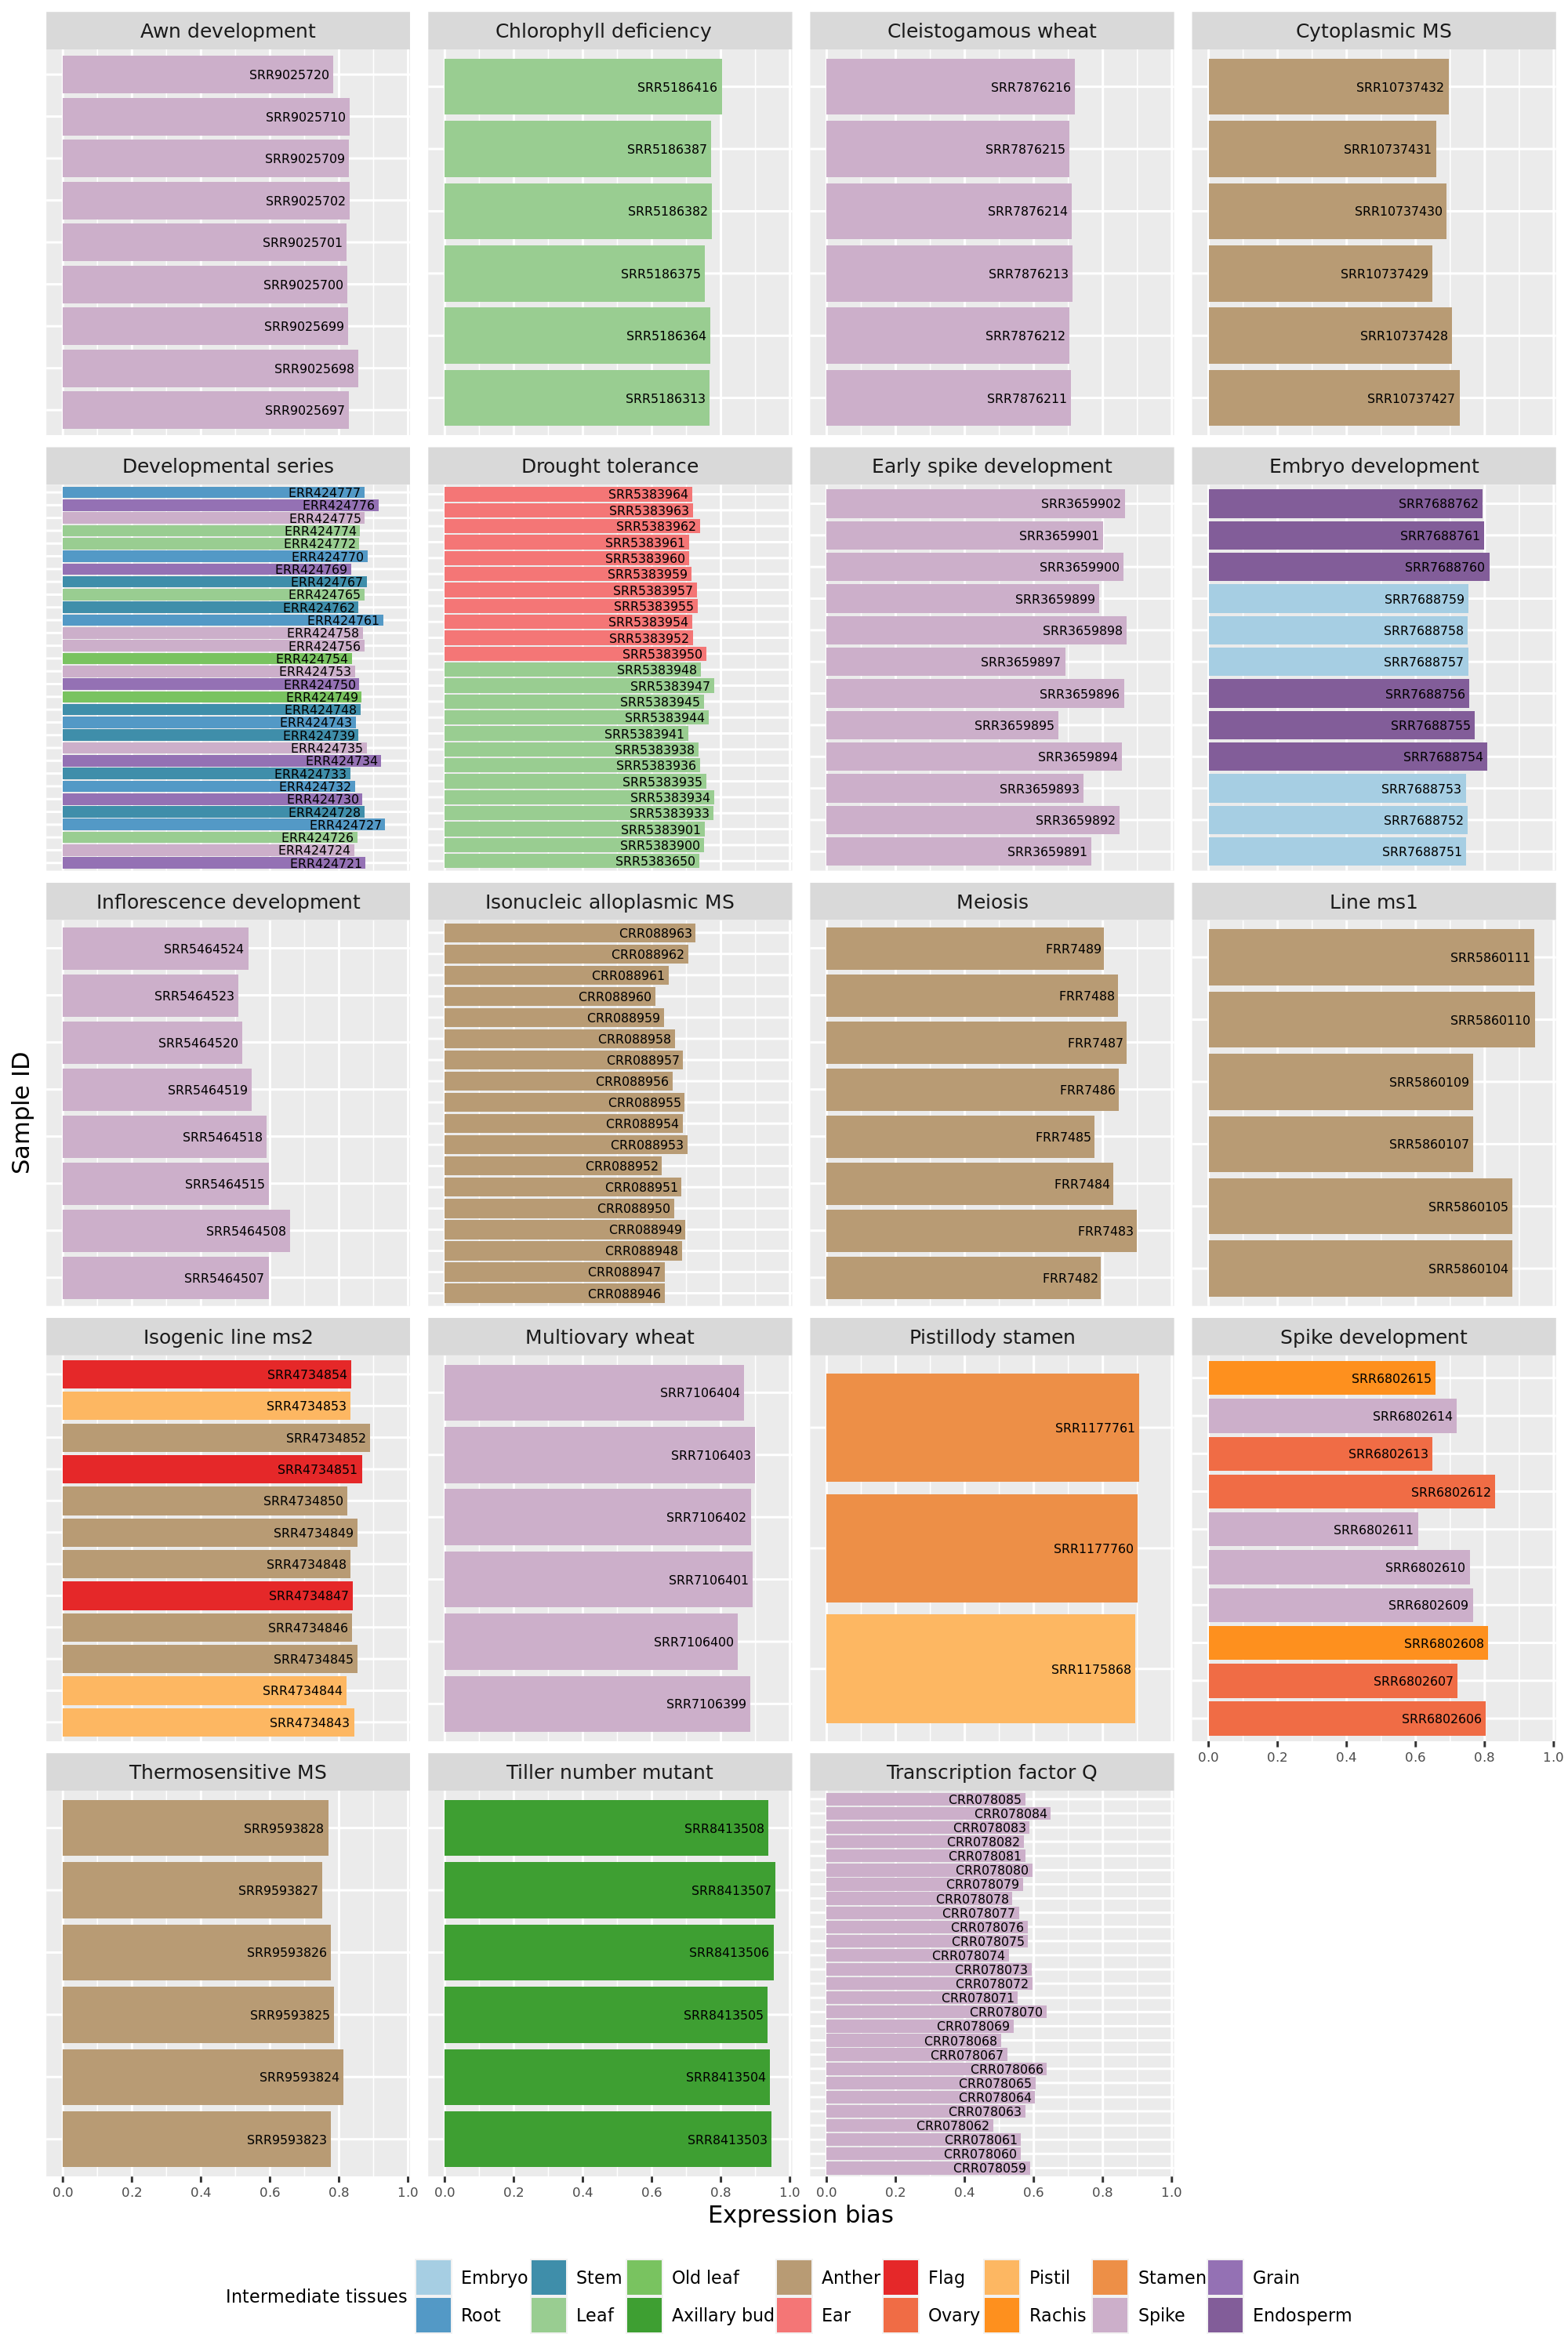

In [35]:
options(repr.plot.width = 10, repr.plot.height = 15, repr.plot.res = 200)

#boxplot is not possible for discrete values! 
#calculation had to be *100 to be able to convert it into integer
expr_bias %>%
    ggplot(aes(x = sample, y = bias, fill = intermediate_tissue)) +
    geom_boxplot() +
    coord_flip() +
    labs(x = "Sample ID", y = "Expression bias") +
    scale_y_continuous(breaks =c(0, 0.2, 0.4, 0.6, 0.8, 1.0)) +
    facet_wrap( ~ dataset, scales= "free_y", ncol = 3) +
    theme(axis.text = element_text(size=6))

cols <- colorRampPalette(brewer.pal(12, "Paired"))
myPal <- cols(length(unique(expr_bias$intermediate_tissue)))

nb.cols <- 19
mycolors <- colorRampPalette(brewer.pal(12, "Paired"))(nb.cols)

labs <- c("Awn development", "Chlorophyll deficiency  ", "Cleistogamous wheat", "Cytoplasmic MS",
          "Developmental series", "Drought tolerance", "Early spike development", "Embryo development",
          "Inflorescence development", "Isonucleic alloplasmic MS", "Meiosis", "Line ms1", 
          "Isogenic line ms2", "Multiovary wheat", "Pistillody stamen", "Spike development", 
          "Thermosensitive MS", "Tiller number mutant", "Transcription factor Q")
names(labs) <- c("awn_dev", "chlorophyll_deficiency", "cleistogamous_wheat", "cytoplasmic_male_sterility",
                 "dev_timecourse_series", "drought_tolerance", "early_spike_dev", "embryo_dev", "inflorescence_dev",
                 "isonuc_allopl_male_sls", "meiosis", "ms1_line", "ms2_isogenic_lines", "multiovary_wheat", 
                 "pistillody_stamen", "spike_dev", "thermosens_male_sterility", "tiller_number_mutant", "transcriptfc_q_mutant")

e1 <- expr_bias %>%
    ggplot(aes(x = sample, y = bias, fill = intermediate_tissue)) +
    geom_col() +
    coord_flip() +
    labs(x = "Sample ID", y = "Expression bias") +
    scale_y_continuous(breaks =c(0, 0.2, 0.4, 0.6, 0.8, 1.0)) +
    facet_wrap( ~ dataset, labeller = labeller(dataset = labs), scales= "free_y", ncol = 4) +
    scale_fill_manual(values = mycolors, name = "Intermediate tissues     ", 
                     limits = c("embryo", "root", "stem",
                                       "leaf", "senescence_leaf", "axillary bud",
                                      "anther", "ear", "flag", "ovary", "pistil", "rachis", "stamen", "spike",
                                      "grain", "endosperm"),
                     labels = c("Embryo", "Root", "Stem",
                                       "Leaf", "Old leaf", "Axillary bud ",
                                      "Anther", "Ear", "Flag", "Ovary", "Pistil", "Rachis", "Stamen", "Spike",
                                      "Grain", "Endosperm")) + 
    theme(axis.text.x = element_text(size = 6), 
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank(),
          strip.text.x = element_text(size = 9), legend.text=element_text(size=8)) +
    geom_text(aes(label = sample, hjust = 1.05), color = "black", size =2)
prow1 <- plot_grid(e1 + theme(legend.position="none"),
                   align = 'vh', hjust = 0, nrow = 1)
legend1 <- get_legend(e1 + guides(fill = guide_legend(nrow = 2)) + theme(legend.position = "bottom", legend.text=element_text(size=8), legend.title=element_text(size=8)))
a1 <- plot_grid(prow1, legend1, ncol = 1, rel_heights = c(1, .05))
a1

setwd("/home/vanda.marosi/floral_development_thesis_vm/figures/")
png("elc_bias_wheat.png", units="in", width=10, height=10, res=300)
plot_grid(prow1, legend1, ncol = 1, rel_heights = c(1, .05))
dev.off()
ggsave("elc_bias_wheat.pdf", plot = a1, width = 10, height = 15)

In [33]:
levels(factor(expr_bias$dataset))

[1] "awn_dev"                    "chlorophyll_deficiency"    
 [3] "cleistogamous_wheat"        "cytoplasmic_male_sterility"
 [5] "dev_timecourse_series"      "drought_tolerance"         
 [7] "early_spike_dev"            "embryo_dev"                
 [9] "inflorescence_dev"          "isonuc_allopl_male_sls"    
[11] "meiosis"                    "ms1_line"                  
[13] "ms2_isogenic_lines"         "multiovary_wheat"          
[15] "pistillody_stamen"          "spike_dev"                 
[17] "thermosens_male_sterility"  "tiller_number_mutant"      
[19] "transcriptfc_q_mutant"

outlier samples: ERR781040 from the Photoperiod mutant dataset, and ERR1457187 from the developmental stages data-set needs to be excluded from further analysis.

In [34]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/vanda.marosi/anaconda3/envs/r/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] gdtools_0.2.2               DESeq2_1.26.0              
 [3] SummarizedExperiment_1.16.0 DelayedArray_0.12.0        
 [5] BiocParallel_1.20.0         matrixStats_0.56.0         
 [7] Biobase_2.46.0              GenomicRanges_1.38.0       
 [9] GenomeInfoDb_1.22.0     